In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Explain PyTextRank: extractive summarization

How does **PyTextRank** perform *extractive summarization* on a text document?

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")

Create some text to use....

In [13]:
text = "The boy was running to catch the bus because he had an appointment with the doctor unfortunately the bus did not arrived on time hence the boy missed his appointment."

Then add **PyTextRank** into the `spaCy` pipeline...

In [14]:
import pytextrank

nlp.add_pipe("textrank", last=True)
doc = nlp(text)

Examine the results: a list of top-ranked phrases in the document

In [27]:
from icecream import ic

for sent in doc.sents:
    ic(sent.start, sent.end)


ic| sent.start: 0, sent.end: 31


In [28]:
for chunk in doc.noun_chunks:
    ic(chunk.text)


ic| chunk.text: 'The boy'
ic| chunk.text: 'the bus'
ic| chunk.text: 'he'
ic| chunk.text: 'an appointment'
ic| chunk.text: 'the doctor'
ic| chunk.text: 'the bus'
ic| chunk.text: 'time'
ic| chunk.text: 'the boy'
ic| chunk.text: 'his appointment'


In [29]:
for ent in doc.ents:
    ic(ent.text, ent.label_, ent.start, ent.end)


In [31]:
import networkx as nx

def increment_edge (graph, node0, node1):
    ic(node0, node1)

    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

In [32]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            ic(visited_tokens, visited_nodes)
            ic(list(range(len(visited_tokens) - 1, -1, -1)))

            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                ic(prev_token, (token.i - visited_tokens[prev_token]))

                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            ic(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes)

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)


In [33]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence


ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 1
    token.text: 'boy'
    token.lemma_: 'boy'
    token.pos_: 'NOUN'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [1], visited_nodes: [0]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 2
ic| node0: 1, node1: 0
ic| token.i: 3
    token.text: 'running'
    token.lemma_: 'run'
    token.pos_: 'VERB'
    visited_tokens: [1]
    visited_nodes: [0]
ic| visited_tokens: [1, 3], visited_nodes: [0, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 2
ic| node0: 2, node1: 1
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 4
ic| token.i: 5
    token.text: 'catch'
    token.lemma_: 'catch'
    token.pos_: 'VERB'
    visited_tokens: [1, 3]
    visited_nodes: [0, 1]
ic| visited_tokens: [1, 3, 5], visited_nodes: [0, 1, 2]
ic| list(range(l

In [34]:
ic(seen_lemma)


ic| seen_lemma: {('appointment', 'NOUN'): {12, 29},
                 ('arrive', 'VERB'): {21},
                 ('boy', 'NOUN'): {1, 26},
                 ('bus', 'NOUN'): {18, 7},
                 ('catch', 'VERB'): {5},
                 ('doctor', 'NOUN'): {15},
                 ('have', 'VERB'): {10},
                 ('miss', 'VERB'): {27},
                 ('run', 'VERB'): {3},
                 ('time', 'NOUN'): {23}}


{('boy', 'NOUN'): {1, 26},
 ('run', 'VERB'): {3},
 ('catch', 'VERB'): {5},
 ('bus', 'NOUN'): {7, 18},
 ('have', 'VERB'): {10},
 ('appointment', 'NOUN'): {12, 29},
 ('doctor', 'NOUN'): {15},
 ('arrive', 'VERB'): {21},
 ('time', 'NOUN'): {23},
 ('miss', 'VERB'): {27}}

In [35]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels


{0: 'boy',
 1: 'run',
 2: 'catch',
 3: 'bus',
 4: 'have',
 5: 'appointment',
 6: 'doctor',
 7: 'arrive',
 8: 'time',
 9: 'miss'}

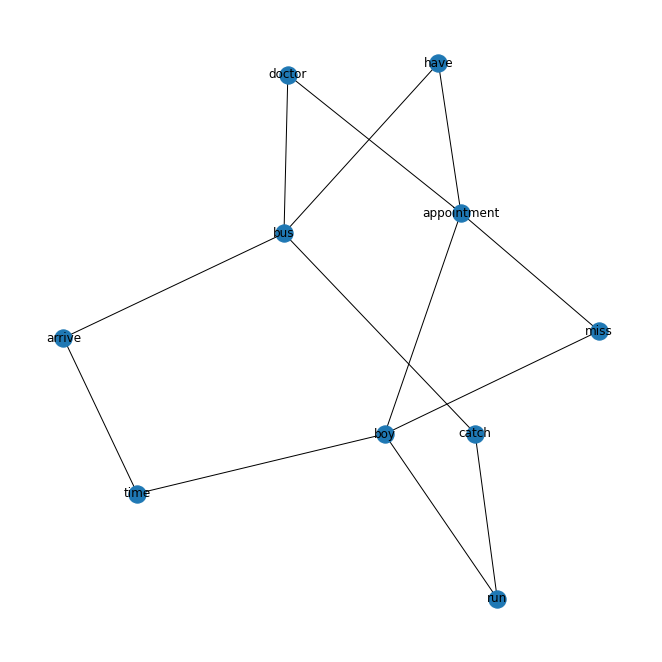

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels);


Construct a list of the sentence boundaries with a phrase vector (initialized to empty set) for each...

In [16]:
sent_bounds = [ [s.start, s.end, set([])] for s in doc.sents ]
sent_bounds

[[0, 31, set()]]

Iterate through the top-ranked phrases, added them to the phrase vector for each sentence...

In [17]:
limit_phrases = 4

phrase_id = 0
unit_vector = []

for p in doc._.phrases:
    ic(phrase_id, p.text, p.rank)
    
    unit_vector.append(p.rank)
    
    for chunk in p.chunks:
        ic(chunk.start, chunk.end)
        
        for sent_start, sent_end, sent_vector in sent_bounds:
            if chunk.start >= sent_start and chunk.end <= sent_end:
                ic(sent_start, chunk.start, chunk.end, sent_end)
                sent_vector.add(phrase_id)
                break

    phrase_id += 1

    if phrase_id == limit_phrases:
        break

ic| phrase_id: 0, p.text: 'time', p.rank: 0.15927549259446053
ic| chunk.start: 23, chunk.end: 24
ic| sent_start: 0, chunk.start: 23, chunk.end: 24, sent_end: 31
ic| phrase_id: 1
    p.text: 'an appointment'
    p.rank: 0.10098029179668527
ic| chunk.start: 11, chunk.end: 13
ic| sent_start: 0, chunk.start: 11, chunk.end: 13, sent_end: 31
ic| phrase_id: 2
    p.text: 'his appointment'
    p.rank: 0.10098029179668527
ic| chunk.start: 28, chunk.end: 30
ic| sent_start: 0, chunk.start: 28, chunk.end: 30, sent_end: 31
ic| phrase_id: 3, p.text: 'the bus', p.rank: 0.09047287141896376
ic| chunk.start: 6, chunk.end: 8
ic| sent_start: 0, chunk.start: 6, chunk.end: 8, sent_end: 31
ic| chunk.start: 17, chunk.end: 19
ic| sent_start: 0, chunk.start: 17, chunk.end: 19, sent_end: 31


Let's take a look at the results...

In [18]:
sent_bounds

[[0, 31, {0, 1, 2, 3}]]

In [19]:
for sent in doc.sents:
    ic(sent)

ic| sent: The boy was running to catch the bus because he had an appointment with the doctor unfortunately the bus did not arrived on time hence the boy missed his appointment.


We also construct a `unit_vector` for all of the phrases, up to the limit requested...

In [20]:
unit_vector

[0.15927549259446053,
 0.10098029179668527,
 0.10098029179668527,
 0.09047287141896376]

Then normalized...

In [21]:
sum_ranks = sum(unit_vector)

unit_vector = [ rank/sum_ranks for rank in unit_vector ]
unit_vector

[0.35260645917757466,
 0.22355167488200153,
 0.22355167488200153,
 0.2002901910584222]

Iterate through each sentence, calculating its *euclidean distance* from the unit vector...

In [22]:
from math import sqrt

sent_rank = {}
sent_id = 0

for sent_start, sent_end, sent_vector in sent_bounds:
    ic(sent_vector)
    sum_sq = 0.0
    ic
    for phrase_id in range(len(unit_vector)):
        ic(phrase_id, unit_vector[phrase_id])
        
        if phrase_id not in sent_vector:
            sum_sq += unit_vector[phrase_id]**2.0

    sent_rank[sent_id] = sqrt(sum_sq)
    sent_id += 1

ic| sent_vector: {0, 1, 2, 3}
ic| phrase_id: 0, unit_vector[phrase_id]: 0.35260645917757466
ic| phrase_id: 1, unit_vector[phrase_id]: 0.22355167488200153
ic| phrase_id: 2, unit_vector[phrase_id]: 0.22355167488200153
ic| phrase_id: 3, unit_vector[phrase_id]: 0.2002901910584222


In [23]:
ic(sent_rank)

ic| sent_rank: {0: 0.0}


{0: 0.0}

Sort the sentence indexes in descending order

In [24]:
from operator import itemgetter

sorted(sent_rank.items(), key=itemgetter(1)) 

[(0, 0.0)]

Extract the sentences with the lowest distance, up to the limit requested...

In [26]:
limit_sentences = 2

sent_text = {}
sent_id = 0

for sent in doc.sents:
    sent_text[sent_id] = sent.text
    sent_id += 1

num_sent = 0

for sent_id, rank in sorted(sent_rank.items(), key=itemgetter(1)):
    ic(sent_id, sent_text[sent_id])
    num_sent += 1
    
    if num_sent == limit_sentences:
        break

ic| sent_id: 0
    sent_text[sent_id]: ('The boy was running to catch the bus because he had an appointment with the '
                         'doctor unfortunately the bus did not arrived on time hence the boy missed '
                         'his appointment.')
